<center><h1>Exercise on Polygenic Scoring (R Version)</h1>
<b>Systems Genetics Lecture - 25.11.21</b></br></br>
<i><small>Arthur Gilly (arthur.gilly@helmholtz-muenchen.de) - Ana Arruda (ana.arruda@helmholtz-muenchen.de)</i></small>
</center>

# Summary
In this exercise, we will apply two polygenic scores to a cohort of 1000 indivuduals. The samples come from the 1000 Genomes project, and the two scores are **a polygenic risk score for Coronary Artery Disease (CAD)** and a **polygenic score for levels of the MEP1B protein**. We will study the influence of ethnicity, see how well these two scores predict the traits in question, and finally, we will examine the polygenicity of these two traits through a genome-wide association.

## Downloading the data and installing libraries

<div class="alert alert-warning">This R notebook uses the <code>data.table</code> library for data manipulation and base R for graphics. In particular, <code>magrittr</code>, <code>ggplot2</code> and <code>tidyr</code> are not supported.</div>

All the libraries you need are already installed and most data files are in the `data` directory.



## Lifting over the polygenic score

We will be working with a CAD score that was downloaded from the publicly available PGS catalog. Variants in that score are identified by chromosome:position, but are on build 37 (also called hg19) of the human reference genome. Our genetic data is on build 38, we must therefore first map these coordinates onto that build. That process is called a liftover. There are R libraries to do this, but they come from the Bioconductor project, and are clunky and hard to use. We will use an external program called CrossMap.

First, we download the dictionary of positions from build 37 to 38 from the USCS Liftover FTP Website.

**Question 1**: Download the chain file from https://hgdownload.cse.ucsc.edu/goldenpath/hg19/liftOver/hg19ToHg38.over.chain.gz

In [1]:
cat(system('
(rm *.chain.gz || echo downloading) && wget https://hgdownload.cse.ucsc.edu/goldenpath/hg19/liftOver/hg19ToHg38.over.chain.gz 2>&1
', intern=T), sep="\n")


downloading
--2021-11-24 08:23:04--  https://hgdownload.cse.ucsc.edu/goldenpath/hg19/liftOver/hg19ToHg38.over.chain.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227698 (222K) [application/x-gzip]
Saving to: 'hg19ToHg38.over.chain.gz'

     0K .......... .......... .......... .......... .......... 22%  451K 0s
    50K .......... .......... .......... .......... .......... 44%  900K 0s
   100K .......... .......... .......... .......... .......... 67%  903K 0s
   150K .......... .......... .......... .......... .......... 89%  190M 0s
   200K .......... .......... ..                              100%  209M=0.2s

2021-11-24 08:23:04 (1001 KB/s) - 'hg19ToHg38.over.chain.gz' saved [227698/227698]



Here is CrossMap's help:

In [2]:
cat(system('
CrossMap.py --help 2>&1
', intern=T), sep="\n")


usage: CrossMap.py [-h] [-v]
                   {bed,bam,gff,wig,bigwig,vcf,gvcf,maf,region,viewchain} ...

CrossMap (v0.6.0) is a program to convert (liftover) genome coordinates
between different reference assemblies (e.g., from human GRCh37/hg19 to
GRCh38/hg38 or vice versa). Supported file formats: BAM, BED, BigWig, CRAM,
GFF, GTF, GVCF, MAF (mutation annotation format), SAM, Wiggle, and VCF.

positional arguments:
  {bed,bam,gff,wig,bigwig,vcf,gvcf,maf,region,viewchain}
                        sub-command help
    bed                 converts BED, bedGraph or other BED-like files. Only
                        genome coordinates (i.e., the first 3 columns) will be
                        updated. Regions mapped to multiple locations to the
                        new assembly will be split. Use the "region" command
                        to liftover large genomic regions. Use the "wig"
                        command if you need bedGraph/bigWig output.
    bam                 conv

As you can see, it supports multiple input formats. We are going to use `bed` as it is the easiest to use. This format is composed of 3 mandatory, tab-separated columns, and an arbitrary number of columns afterwards. The 3 columns are `chr    pos-1    pos`. 


**Question 2:** Read in the CAD score (`data/PGS000337.txt.gz`) and make it compatible with the BED format.

In [3]:
library(data.table)
cadscore=fread("data/PGS000337.txt.gz")

In [4]:
cadscore[,start:=chr_position - 1]
setcolorder(cadscore, c("chr_name", "start", colnames(cadscore)[2:5]))
fwrite(cadscore, "cad.bed", col.names=F, sep="\t", quote=F)

**Question 3:** Use `CrossMap bed` to convert the positions in the CAD score from build 37 to build 38.

In [6]:
cat(system('
CrossMap.py bed hg19ToHg38.over.chain.gz cad.bed cad.38.bed 2>&1
', intern=T), sep="\n")


2021-11-24 08:28:20 [INFO]  Read the chain file "hg19ToHg38.over.chain.gz" 


**Question 4:** Read in the lifted over file, remove the second column (`pos - 1`), remove any position that maps outside of the autosomes (chr1-chr22), and check that no variant maps to several positions on build 38.

In [7]:
liftedover=fread("cad.38.bed")

In [8]:
setnames(liftedover, colnames(cadscore))
head(liftedover)

chr_name,start,chr_position,effect_allele,effect_weight,variant_description
<chr>,<int>,<int>,<chr>,<dbl>,<chr>
1,1023850,1023851,A,0.0113215,1:959231:G:A
1,1184477,1184478,T,-0.0165875,1:1119858:C:T
1,1186643,1186644,C,0.0135431,1:1122024:T:C
1,1219477,1219478,T,-0.0243073,1:1154858:C:T
1,1236036,1236037,T,-0.0126844,1:1171417:C:T
1,1274971,1274972,G,-0.0193357,1:1210352:A:G


In [9]:
liftedover[,start:=NULL]

In [10]:
nrow(liftedover)

[1] 75001

In [11]:
liftedover=liftedover[chr_name %in% 1:22,]

In [12]:
nrow(liftedover)

[1] 74999

In [13]:
ct=liftedover[,.N,by=variant_description]

**Question 5:** Create a tab-separated, headerless score file for your lifted over CAD score, with the following columns :
* `id` which has the form chr1:1234
* `effect_allele`
* `effect_weight`

In [14]:
cadscore=liftedover
cadscore[,id:=paste0("chr", chr_name, ":", chr_position)]
fwrite(cadscore[,c("id", "effect_allele", "effect_weight")], "CAD.score", sep="\t", col.names=F, quote=F)

**Question 6:** Do the same for the MEP1B protein score located at `data/MEP1B.gilly.prs.txt`. The coordinates in that file are already in build 38, you only need to reformat the file, not lift it over.

In [15]:
mepscore=fread("data/MEP1B.gilly.prs.txt")

In [16]:
mepscore[,id:=paste0("chr", chr, ":", pos)]
fwrite(mepscore[,c("id", "A1", "effect")], "MEP1B.score", sep="\t", col.names=F, quote=F)

In [17]:
cat(system('
head *.score
', intern=T), sep="\n")

==> CAD.score <==
chr1:1023851	A	0.0113215
chr1:1184478	T	-0.0165875
chr1:1186644	C	0.0135431
chr1:1219478	T	-0.0243073
chr1:1236037	T	-0.0126844
chr1:1274972	G	-0.0193357
chr1:1276547	T	-0.0211415
chr1:1277415	A	-0.0213939
chr1:1279698	G	-0.0209343
chr1:1284756	G	-0.0178729

==> MEP1B.score <==
chr18:32038169	T	-0.2891709
chr18:32067215	C	0.4230704
chr18:32208550	G	-0.6470447
chr18:32224458	T	-0.6871607
chr18:32224900	A	-1.070113
chr18:32317264	C	-0.556034
chr18:32337385	C	0.3294772


## Applying scores

We will now apply the scores to a cohort of 1,000 individuals. From the lecture, you will remember that we need genotype data for these individuals as well as the weights contained in the score files above. We will first use PLINK, a popular genetic toolbox installed in this environment. Then we will do it manually, and compare the results.

### Method 1 : using PLINK

**Question 7:** Check the PLINK 1.9 user manual for applying risk scores and create two score profiles. Use the `data/autosomal.forPRS.{bed|bim|fam}` dataset for genotypes and the score files you have created in questions 6 and 7.

In [20]:
cat(system('
plink --bfile data/autosomal.forPRS --score CAD.score --out CAD
plink --bfile data/autosomal.forPRS --score MEP1B.score --out MEP1B
', intern=T), sep="\n")

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CAD.log.
Options in effect:
  --bfile data/autosomal.forPRS
  --out CAD
  --score CAD.score

52229 MB RAM detected; reserving 26114 MB for main workspace.
75624 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to CAD.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999812.
75624 variants and 2504 people pass filters and QC.
Note: No phenotypes present.
--score: 74813 valid predictors loaded.
--score: Results written to 

#### Visualising scores

**Question 8:** Visualise the distributions of scores for the two scores you have just calculated. Comment on the distribution shape for both scores.

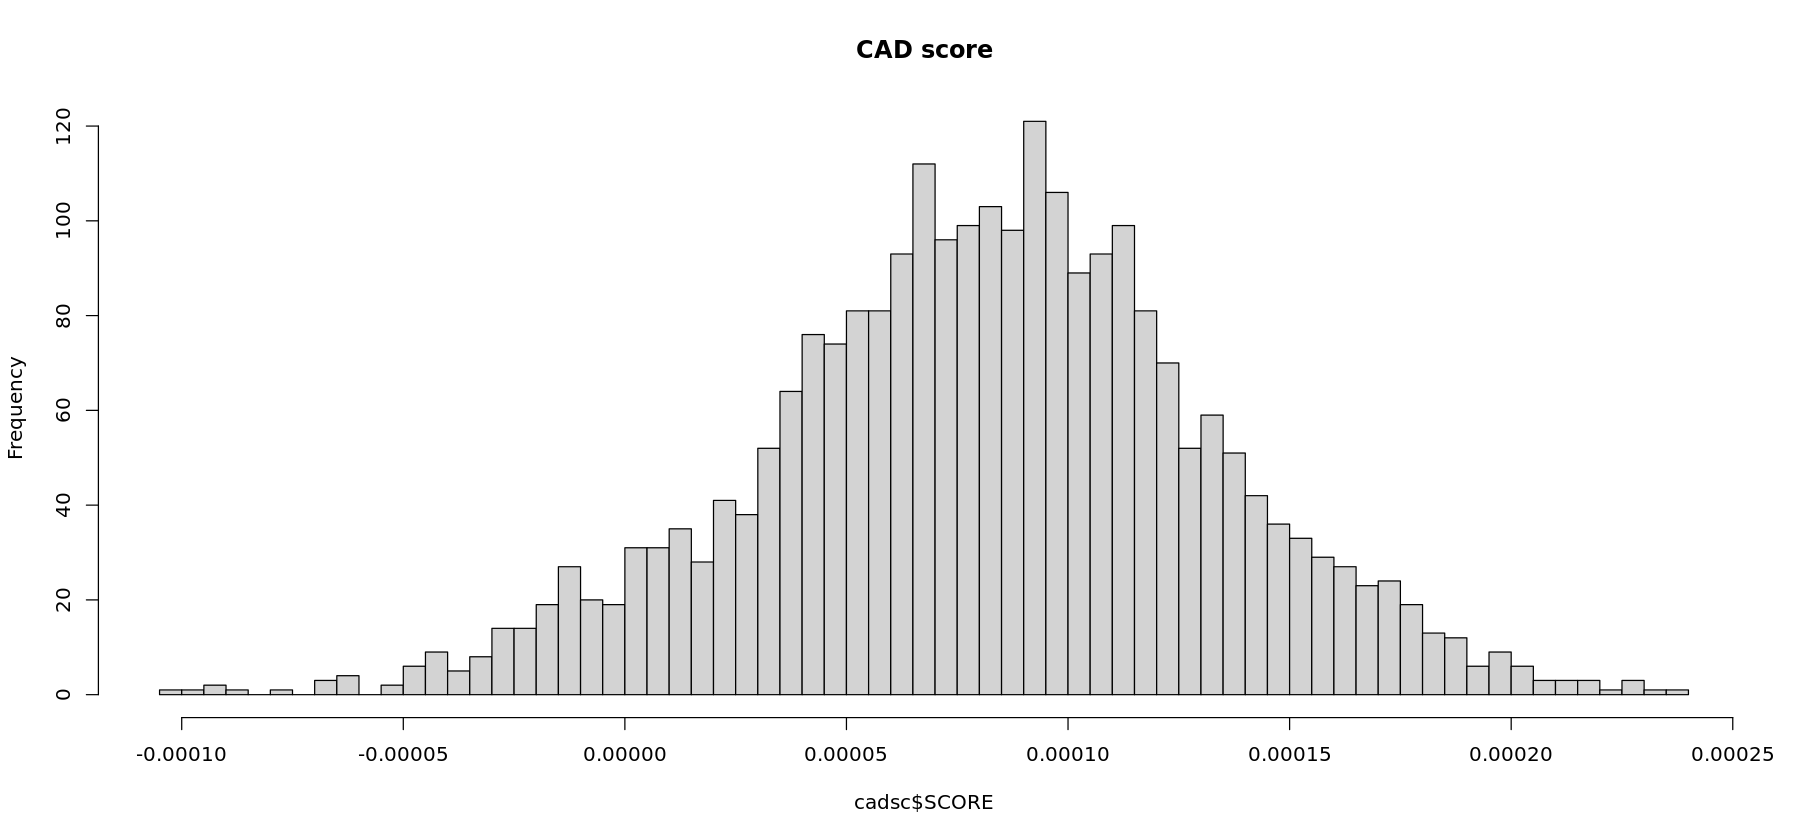

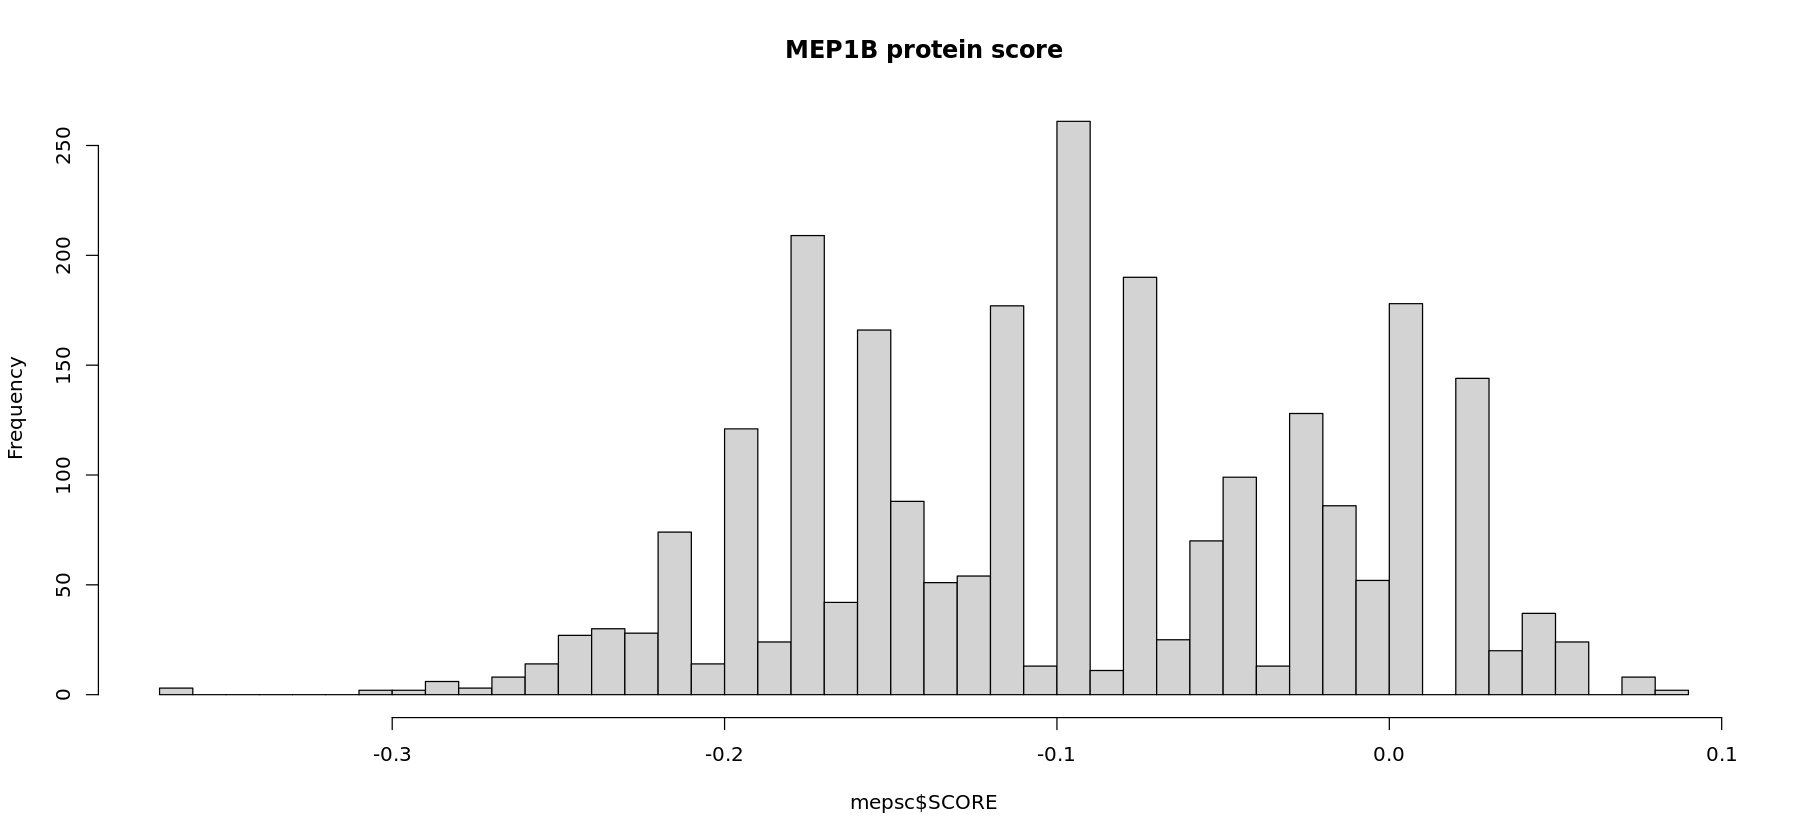

In [21]:
cadsc=fread("CAD.profile")
options(repr.plot.width=15)
hist(cadsc$SCORE, breaks=61, main="CAD score")
mepsc=fread("MEP1B.profile")
hist(mepsc$SCORE, breaks=41, main="MEP1B protein score")

The MEP1B score is much less well-behaved and deviates markedly from the normal assumption.

### Method 2: Manually applying scores (bonus section, only if you are proficient with data.table and/or data wrangling in R)

We do not exactly know what PLINK did for us. We can repeat the process manually using R data.table's data manipulation tools.

**Question 9:** Load the `autosomal.forPRS.mx.traw` file. It is a matrix of genotypes with positions as rows and samples as columns. There are 7 "header" columns describing each position. For each score, restrict the dataframe to the positions in the score file, then apply an element-wise multiplication column by column, and sum the weighted genotypes: $score_j=\sum_{i \in SNPs}w_i*g_i$ where $i$ denotes SNPs and $j$ denotes individuals. For the CAD score, beware that the score file and genotype file do not contain the same variants, and that alleles may be different even if they are present.

In [23]:
genos=fread("data/autosomal.forPRS.mx.traw")
famfile=fread("data/PRS.course.testset.fam")
tokeep=paste(famfile$V1, famfile$V2, sep="_")
tokeep=c(colnames(genos)[1:6], tokeep)
genos=genos[,..tokeep]


In [24]:
head(genos)

CHR,SNP,(C)M,POS,COUNTED,ALT,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00100_HG00100,...,NA21128_NA21128,NA21129_NA21129,NA21130_NA21130,NA21133_NA21133,NA21135_NA21135,NA21137_NA21137,NA21141_NA21141,NA21142_NA21142,NA21143_NA21143,NA21144_NA21144
<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1:1023851,0,1023851,A,G,0,1,2,1,...,1,2,1,0,0,0,2,1,1,0
1,chr1:1184478,0,1184478,T,C,0,0,0,0,...,0,1,0,0,1,0,1,1,1,0
1,chr1:1186644,0,1186644,C,T,0,0,0,0,...,1,0,2,1,0,1,1,1,1,0
1,chr1:1219478,0,1219478,T,C,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr1:1236037,0,1236037,C,T,1,1,2,1,...,1,0,0,0,1,1,0,0,0,1
1,chr1:1274972,0,1274972,G,A,0,0,0,0,...,0,1,1,1,0,1,1,2,2,0


In [25]:
spnames=colnames(genos)[7:ncol(genos)]

In [26]:
mepg=genos[SNP %in% mepscore$id]

In [27]:
mepg

CHR,SNP,(C)M,POS,COUNTED,ALT,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00100_HG00100,...,NA21128_NA21128,NA21129_NA21129,NA21130_NA21130,NA21133_NA21133,NA21135_NA21135,NA21137_NA21137,NA21141_NA21141,NA21142_NA21142,NA21143_NA21143,NA21144_NA21144
<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
18,chr18:32038169,0,32038169,T,C,0,1,1,2,...,0,1,1,1,1,2,0,1,0,1
18,chr18:32067215,0,32067215,C,T,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,chr18:32208550,0,32208550,G,C,0,1,1,0,...,1,1,0,0,0,1,0,0,2,1
18,chr18:32224458,0,32224458,T,C,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18,chr18:32224900,0,32224900,A,T,2,2,1,0,...,1,1,1,2,1,1,0,0,2,2
18,chr18:32317264,0,32317264,C,G,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
18,chr18:32337385,0,32337385,C,T,1,2,0,1,...,1,1,1,0,2,2,1,1,2,1


In [28]:
mepscore

chr,pos,A1,A2,effect,id
<int>,<int>,<chr>,<chr>,<dbl>,<chr>
18,32038169,T,C,-0.2891709,chr18:32038169
18,32067215,C,T,0.4230704,chr18:32067215
18,32208550,G,C,-0.6470447,chr18:32208550
18,32224458,T,C,-0.6871607,chr18:32224458
18,32224900,A,T,-1.0701130,chr18:32224900
18,32317264,C,G,-0.5560340,chr18:32317264
18,32337385,C,T,0.3294772,chr18:32337385


In [29]:
mepg=colSums(mepg[,lapply(.SD, function(x) x*mepscore$effect), .SDcol=spnames])

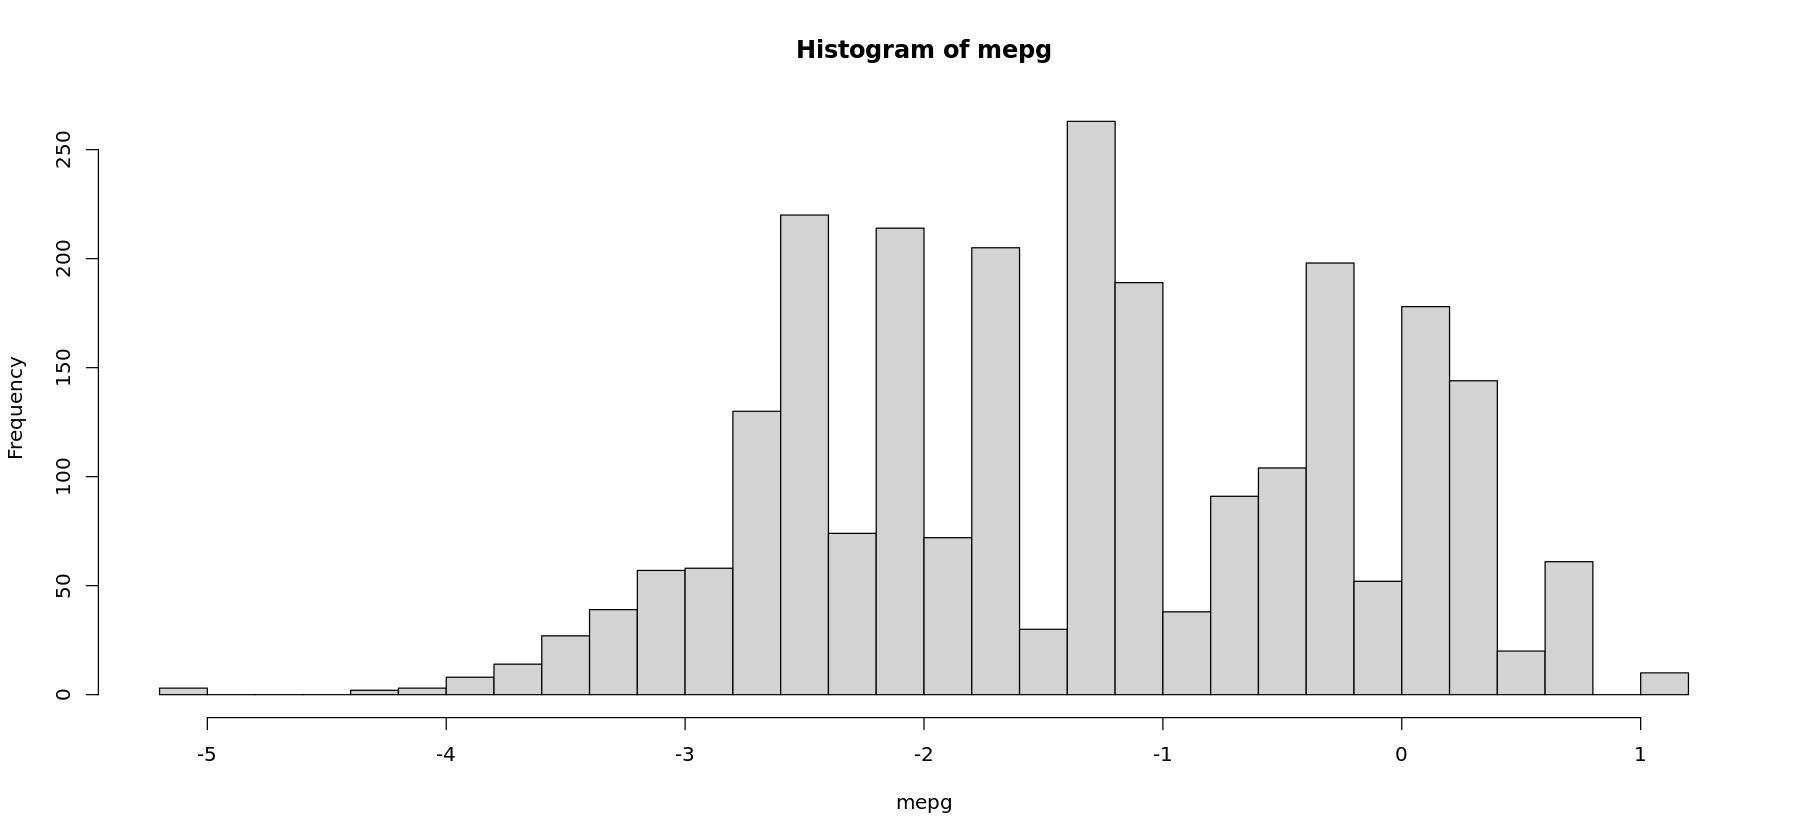

In [30]:
hist(mepg, breaks=41)

<div class="alert alert-warning"> You might be thinking of <code>cadg=genos[SNP %in% cadscore$id]</code> which usually works. But this binder has very low memory, so a merge is more efficient. Don't forget to <code>gc()</code> from time to time to free up memory.

In [ ]:
cadg=merge(cadscore, genos, by.x="id", by.y="SNP")

In [ ]:
rm(genos)
gc()

In [ ]:
cadg[,eff:=effect_weight]
cadg[effect_allele==ALT,eff:=-1*eff]
cadg=cadg[effect_allele==ALT | effect_allele == COUNTED]
cadg=cadg[,lapply(.SD, function(x) sum(x*eff, na.rm=T)), .SDcol=spnames]